In [3]:
import pandas as pd
import numpy as np
import csv

from glob import glob
import os
import json
import io

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from backtrader_plotting import Bokeh
from backtrader_plotting.schemes import Tradimo
from bokeh.plotting import figure, output_file, save

import swifter
import ta
import backtrader as bt

from utils.common_utils import get_root_dir

In [4]:
class PandasData_Custom(bt.feeds.PandasData):
    lines = ('macd',)
    params = (
        ('datetime', 0),
        ('open', 1),
        ('high', 2),
        ('low', 3),
        ('close', 4),
        ('volume', 5),
        ('macd', 6)
    )

In [5]:
class tradeStrategy(bt.Strategy):
    def __init__(self):
        global long_macd_threshold, long_per_threshold, long_close_threshold, short_macd_threshold, short_per_threshold, short_close_threshold
        self.long_macd_threshold = long_macd_threshold
        self.long_per_threshold = long_per_threshold
        self.long_close_threshold = long_close_threshold
        
        self.short_macd_threshold = short_macd_threshold
        self.short_per_threshold = short_per_threshold
        self.short_close_threshold = short_close_threshold
        
        global symbol
        self.symbol = symbol
        self.current_positions = {}
        self.current_positions[self.symbol] = 0
        
        
        self.dataopen = self.datas[0].open
        self.dataclose = self.datas[0].close
        
        self.macd = self.datas[0].macd
        
        self.buy_percentage = 0
        self.order=None
        self.buyprice=None
        self.buycomm=None
        self.position_time=None
        
        self.trades = io.StringIO()
        self.trades_writer = csv.writer(self.trades)
        
        self.operations = io.StringIO()
        self.operations_writer = csv.writer(self.operations)
        
        self.portfolioValue = io.StringIO()
        self.portfolioValue_writer = csv.writer(self.portfolioValue)
        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.datetime(0)
#         print("Datetime: {} Message: {} Percentage: {}".format(dt, txt, self.buy_percentage))
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                ordertype = "BUY"
                #self.log("BUY EXECUTED, Price: {}, Cost: {}, Comm: {}".format(order.executed.price, order.executed.value, order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                ordertype = "SELL"
                #self.log("SELL EXECUTED, Price: {}, Cost: {}, Comm: {}".format(order.executed.price, order.executed.value, order.executed.comm))

            self.trades_writer.writerow([self.datas[0].datetime.datetime(0), ordertype, order.executed.price, order.executed.value, order.executed.comm])
        
            self.bar_executed = len(self)
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log("Order Canceled/Margin/Rejected")
            self.log(order.Rejected)
            self.trades_writer.writerow([self.datas[0].datetime.datetime(0) , 'Rejection', 0, 0, 0])
            
        self.order = None
    
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        
        self.log('OPERATION PROFIT, GROSS: {}, NET: {}'.format(trade.pnl, trade.pnlcomm))
        self.operations_writer.writerow([self.datas[0].datetime.datetime(0), trade.pnlcomm])
    
    def get_logs(self):
        '''
        Returns:
        ________
        portfolioValue (df):
        Date and Value of portfolio
        
        trades (df):
        'Date', 'Type', 'Price', 'Total Spent', 'Comission'
        
        operations (df):
        'Date', 'Profit'
        '''
        self.portfolioValue.seek(0)
        portfolioValueDf = pd.read_csv(self.portfolioValue, names=['Date', 'Value'])
        
        portfolioValueDf['Date'] = pd.to_datetime(portfolioValueDf['Date'])
        portfolioValueDf = portfolioValueDf.set_index('Date')
        portfolioValueDf = portfolioValueDf.resample('1D').agg({'Date': lambda x: x.iloc[0], 'Value': lambda x: x.iloc[-1]})['Date']
        
        self.trades.seek(0)
        tradesDf = pd.read_csv(self.trades, names=['Date', 'Type', 'Price', 'Total Spent', 'Comission'])
        
        self.operations.seek(0)
        operationsDf = pd.read_csv(self.operations, names=['Date', 'Profit'])
        
        return portfolioValueDf.reset_index(), tradesDf, operationsDf
    
    
    def next(self):
        self.portfolioValue_writer.writerow([self.datas[0].datetime.datetime(0), self.broker.getvalue()])
        
        if self.order:
            return
        
        per_change = ((self.dataopen[0]/self.dataopen[-4]) - 1) * 100
        
        total_possible_size = (self.broker.get_cash()/self.dataopen[0]) * 0.95
        
            
        if not self.position:
            if self.macd > self.long_macd_threshold and per_change < self.long_per_threshold:
                self.log("LONG CREATE {}".format(self.dataopen[0]))
                self.current_positions[self.symbol] = total_possible_size
                
                self.order = self.buy(size=self.current_positions[self.symbol])
            elif self.macd < self.short_macd_threshold and per_change > self.short_per_threshold:
                self.log("SHORT CREATE {}".format(self.dataopen[0]))
                self.current_positions[self.symbol] = total_possible_size
                
                self.order = self.sell(size=self.current_positions[self.symbol])
        else:
            if self.position.size > 0:         
                #LONG OPEN
                if self.macd < self.long_close_threshold:
                    self.log("LONG CLOSE {}".format(self.dataopen[0]))
                    self.order = self.sell(size=self.current_positions[self.symbol])
                    
                    if self.macd < self.short_macd_threshold and per_change > self.short_per_threshold:
                        self.log("SHORT CREATE {}".format(self.dataopen[0]))
                        self.current_positions[self.symbol] = total_possible_size

                        self.order = self.sell(size=self.current_positions[self.symbol])
                else:
                    self.log("HODL {}".format(self.dataopen[0]))
                                
            elif self.position.size < 0:
                if self.macd > self.short_close_threshold:
                    self.log("SHORT CLOSE {}".format(self.dataopen[0]))
                    self.order = self.buy(size=self.current_positions[self.symbol])
                    
                    if self.macd > self.long_macd_threshold and per_change < self.long_per_threshold:
                        self.log("LONG CREATE {}".format(self.dataopen[0]))
                        self.current_positions[self.symbol] = total_possible_size

                        self.order = self.buy(size=self.current_positions[self.symbol])
                else:
                    self.log("HODL {}".format(self.dataopen[0]))

In [6]:
global n_fast
global n_slow

global long_macd_threshold
global long_per_threshold
global long_close_threshold
global short_macd_threshold
global short_per_threshold
global short_close_threshold
global symbol

n_fast = 24
n_slow = 52

long_macd_threshold = 2
long_per_threshold = 1
long_close_threshold = 1
short_macd_threshold = -1
short_per_threshold = -1
short_close_threshold = 0.5
symbol = 'XMR'

In [7]:
features_file = get_root_dir() + "/data/features/{}.csv".format(symbol)


df = pd.read_csv(features_file)
    
df['macd'] = ta.trend.macd(df['sentistrength_total'], n_fast=n_fast, n_slow=n_slow, fillna=True)
df['macd'] = df['macd'].fillna(0)

df['Time'] = pd.to_datetime(df['Time'])

json_data = {}    

json_data['mean'] = df['macd'].mean()
json_data['std'] = df['macd'].std()

df['macd'] = (df['macd'] - json_data['mean'])/json_data['std']

In [8]:
curr_dir = get_root_dir() + "/data/backtest/{}".format(symbol)

In [9]:
df = df[['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'macd']]

In [10]:
df = df.dropna(subset=['Time'])

In [11]:
data = PandasData_Custom(dataname=df)
cerebro = bt.Cerebro(cheat_on_open=True, maxcpus=None)
cerebro.adddata(data)

cerebro.addstrategy(tradeStrategy)

cerebro.addanalyzer(bt.analyzers.SharpeRatio_A)
cerebro.addanalyzer(bt.analyzers.Calmar)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer)

initial_cash = 10000
comission = 0.1

cerebro.broker.setcash(initial_cash)
cerebro.broker.setcommission(comission/100)

run = cerebro.run()

9

In [41]:
analysis['total']['open']

1

In [43]:
portfolioValue, trades, operations = run[0].get_logs()

/home/warproxxx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



In [ ]:
def save_plot(cerebro, curr_dir):
    output_file(curr_dir + "/backtest.html")
    b = Bokeh(style='bar', plot_mode="tabs", scheme=Tradimo())
    b.plot_result(run)
    
    figure = cerebro.plot(style ='candlebars')[0][0]
    figure.savefig(curr_dir + "/backtest.png")

<IPython.core.display.Javascript object>


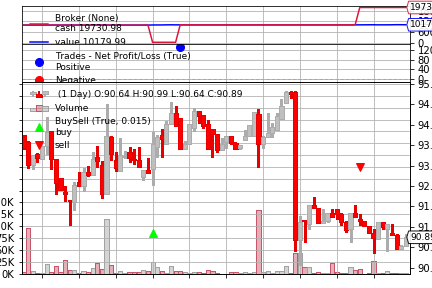

In [57]:
save(a.figures[0])

ValueError: OutputDocumentFor expects a sequence of Models

In [43]:
get_bokeh_plot(cerebro, curr_dir)

ValueError: OutputDocumentFor expects a sequence of Models

In [29]:
output_file(curr_dir + "/backtest.html")
b = Bokeh(style='bar', plot_mode="tabs", scheme=Tradimo())
fig = cerebro.plot(b)

In [21]:
from bokeh.embed import file_html
from bokeh.resources import CDN

In [23]:
html = file_html(b, CDN, "my plot")

ValueError: OutputDocumentFor expects a sequence of Models

In [15]:
fig = fig[0][0]

In [18]:
b.savefig(fig, 'a.html')

TypeError: savefig() missing 4 required positional arguments: 'width', 'height', 'dpi', and 'tight'

In [10]:
#ISSUE IS BOKEH PLOTTING AT WRONG DIRECTORY

b = Bokeh(style='bar', plot_mode="tabs", scheme=Tradimo())
fig = cerebro.plot(b)
# output_file(plot_dir)

In [53]:
r = run[0]

In [54]:
r.analyzers.getnames()

['sharperatio_a', 'calmar', 'drawdown', 'returns', 'tradeanalyzer']

In [55]:
r.analyzers.getbyname('tradeanalyzer').get_analysis()

AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 9), ('open', 0), ('closed', 9)])),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 1),
                                                     ('longest', 2)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 1)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      1527.3992468010572),
                                                     ('average',
                                                      169.7110274223397)])),
                                   ('net',
                                    AutoOrderedDict([('total',
                                     

In [36]:
r.observers.getnames()

['broker', 'trades']

In [38]:
b = r.observers.getbyname('broker')

In [41]:
b

[]

In [56]:
portfolioValue, trades, operations = run[0].get_logs()

/home/warproxxx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



In [57]:
portfolioValue

,Date,Value
0,2019-08-09,10000.000000
1,2019-08-10,10000.000000
2,2019-08-11,10000.000000
3,2019-08-12,10000.000000
4,2019-08-13,9988.295391
5,2019-08-14,10180.483246
6,2019-08-15,11002.707097
7,2019-08-16,10980.335931
8,2019-08-17,11004.529355
9,2019-08-18,11130.291228


In [26]:
portfolioValue, trades, operations = run[0].get_logs()

/home/warproxxx/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:94: FutureWarning:

using a dict with renaming is deprecated and will be removed in a future version



<IPython.core.display.Javascript object>


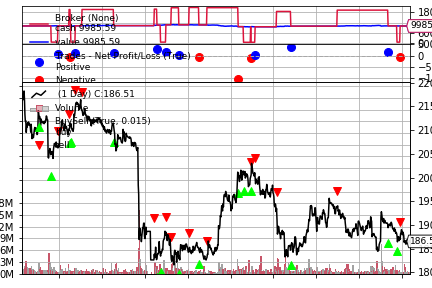

[[<Figure size 432x288 with 4 Axes>]]

In [27]:
cerebro.plot()

In [15]:
trades

,Date,Type,Price,Total Spent,Comission
0,2019-08-09 08:30:00,BUY,11873.42,9533.336996,9.533337


In [28]:
portfolioValue

,Date,Value
0,2019-08-09,10000.000000
1,2019-08-10,10000.000000
2,2019-08-11,10064.148561
3,2019-08-12,10087.191353
4,2019-08-13,10213.423383
5,2019-08-14,10201.742603
6,2019-08-15,10201.742603
7,2019-08-16,10662.389405
8,2019-08-17,10684.844208
9,2019-08-18,10466.050461
